In [1]:
import praw
from praw.models import MoreComments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import stylecloud
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

In [2]:
reddit = praw.Reddit(client_id='Uqa0qPvYrRATm6WB2yy6vw', client_secret='ExLLWnJZrEJ5XrSdU9GQ074YOoOg5A', user_agent='sentiment')

In [3]:
def get_whole_thread(submission):
    # d = {}
    comments = []
    for top_level_comment in submission.comments:
        # print("COMMENT:")
        # print(top_level_comment.body)
        # d[top_level_comment.body] = []
        comments.append(top_level_comment.body)
        replies = []
        replies.extend(top_level_comment.replies)
        while replies:
            reply = replies.pop(0)
            if isinstance(reply, MoreComments):
                continue
            # print("    SUBCOMMENT:")
            # print(reply.body)
            # d[top_level_comment.body].append(reply.body)
            comments.append(reply.body)
            # print("________")
            replies = list(reply.replies) + replies
    return comments

In [4]:
subreddit = reddit.subreddit("SGExams")
cnt = 0
posts = []
print("start")
for submission in subreddit.search("smu"):
    post = []
    post.append(submission.title)
    post.append(submission.selftext)
    comments = get_whole_thread(submission)
    post.append(comments)
    posts.append(post)

print('end')

start
end


In [17]:
df = pd.DataFrame(posts,columns=['title', 'body', 'comments'])
#print(df)
# df.to_csv("reddit_sg_exams.csv", sep='\t')
df.head()

,title,body,comments
0,[Uni] SMU Applications 2022 Megathread,Feel free to interact with seniors and other ...,[Here are some redditors that have kindly open...
1,[UNI] SMU Interview Offers,"Hello!\n\nAs per the title above, has anyone r...","[Seems like Biz, Law, CS, IS have received DIs..."
2,[Uni] SMU Business Admissions Interview,Hey!! I just got the email notifying me that I...,[Hi i did the interview last year and passed.\...
3,[UNI] SMU law written test attire,hi 😭😭 does anyone know what office wear consti...,"[Idh office attire… so wear smart 4 ah 😂, well..."
4,[UNI] SMU Law applicants,"Hello guys, I’ve been seeing a lot of posts he...",[I think some ppl submitted their application ...


In [23]:
#Show the titles that contain NUS, CS, SMU
only_nus = df[df['title'].str.contains('NUS')]
qn_content =""
for line in only_nus['title']:
    if 'nus' in line.lower() and 'cs' in line.lower() and 'smu' in line.lower(): 
        qn_content += line.lower() + ' '    
        print(line)

[Uni] NUS CS or SMU Software Engineering (considering my circumstances)?
[Uni] SMU cs or NUS cs


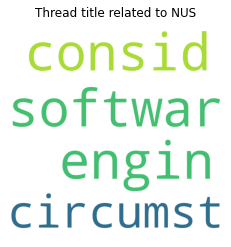

In [24]:
#Cloud word for titles that contain NUS, SMU CS
stop_words = stopwords.words('english')
stop_words.extend(['nus', 'uni', 'smu', 'cs', 'vs', 'level', 'levels'])

qn_content = ''
for line in df['title']:
    if 'nus' in line.lower() and 'cs' in line.lower() and 'smu' in line.lower():
        qn_content += line.lower() + ' '    
        #print(line)

# Tokenize Words
tokenizer = RegexpTokenizer(r'\w+')
words_content = tokenizer.tokenize(qn_content)  # All answers for that question into words

# Remove stop words
words_filtered = []
for w in words_content:
    if w not in stop_words:
        words_filtered.append(w)

# Porter Stemmer
porter_stemmer = PorterStemmer()

words_stemmed = []
for w in words_filtered:
    words_stemmed.append(porter_stemmer.stem(w))

# WordCloud
words_joined = " ".join([w for w in words_stemmed])

# Create a word cloud
my_wordcloud = WordCloud(background_color='white',
                     width=1000,
                     height=1000).generate(words_joined)

plt.imshow(my_wordcloud)
plt.axis('off')
plt.title('Thread title related to NUS')
plt.show()

In [58]:
only_nus = df[df['title'].str.contains('NUS')]
only_nus = only_nus[only_nus['title'].str.contains('CS')]
only_nus = only_nus[only_nus['title'].str.contains('SMU')]
only_nus.head()

,title,body,comments
33,[Uni] NUS CS or SMU Software Engineering (cons...,"Y3 poly student here, my family and friends th...",[I think a good foundation in Math & theory is...


In [54]:
# original stopwords
def original_stopwords():
    return stopwords.words('english')

In [26]:
def extract_text(df):
    for(columnName, columnData) in df.iteritems():
        qn_content = []
        for line in df[columnName]:
            if len(line.strip()) > 0: # Eliminates empty answers
                qn_content.append(line)
    return qn_content

In [59]:
# Helper Function for Tokenisation of text content, returns a list of word or words depending on ngrams defined
import string

def token_fn(sentence_list, n, stop_words_custom):
    output = []
    output2 = []
    for line in sentence_list:
        #remove punctuations
        new_string = line.translate(str.maketrans('', '', string.punctuation))
        new_string = new_string.replace('“', '')
        new_string = new_string.replace('”', '')
        
        x = new_string.split()
        
        for word in x:
            if word not in stop_words_custom:
                #print(word)
                output.append(word)

        sentence = ""
        for word in output:
            sentence += word + " "
        
        token = word_tokenize(sentence)
        gram = list(ngrams(token, n))

        if n == 1:
            for content in gram:
                for word in content:
                    output2.append(word)  
        else:
            for content in gram:
                link = ''
                for word in content:
                    link += word + '_'
                link = link[:-1]
                output2.append(link)
                
    return output2

def wc_fn(word_list, title, no_word_max):
    words_joined = " ".join([w for w in word_list])
    my_wordcloud = WordCloud(background_color='white', max_words = no_word_max, 
                             max_font_size = 1000,
                             width=3000,
                             height=2000).generate(words_joined)
    plt.imshow(my_wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

Y3 poly student here, my family and friends think I should aim to enter CS because it's seen as a "prestigious" degree with good career prospects. With my math qualification, related diploma course, and cGPA (currently 3.95), I should have no issues with getting in. 

Problem is that I still feel too dumb for a CS degree when I hear there's going to be a lot of math and theory involved, and I'm frankly not good at maths and don't like getting too in-depth with theory. Instead, I'm looking at SMU Software Engineering Work-Study Degree because I enjoy a more "practical" curriculum and because I'm already working towards being a web developer.

I presume that I might have an easier time in SMU as I further my skill set in web development vs in NUS where I'll be suffering everyday, competing against much smarter and hardworking individuals.

I'm posting here to see if anyone has any thoughts on this and to see if anyone can manage to convince me that I should study CS instead.


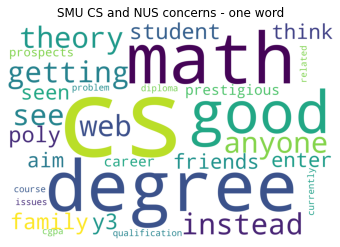

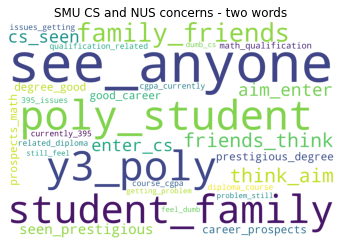

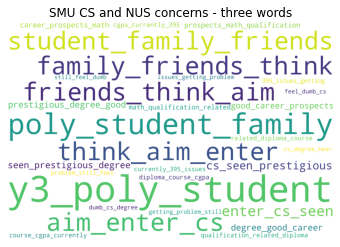

In [60]:
# # Top commmon body for SMU & NUS

smu_nus_body = only_nus.iloc[:, [1]]

sw = original_stopwords()
sw.extend(['exactly','x200b' , 'nus', 'smu','boil','nt', "n't",'rlly', 'u','hi', 'tat', 'much', 'sure', 'im', 'thank', 'really', "i'm", 'lol', 'bro', 'cmi', 
           'hahah' , 'one', 'well', 'hey', 'hey,' , 'also', 'would' , 'bat', 'right'])

sentences = []
for sentence in smu_nus_body["body"]:
    #sentences = []
    if len(sentence.lower().strip()) > 0 and 'https' not in sentence.lower():
        print(sentence)
        sentences.append(sentence.lower())
    
    
single_word = token_fn(sentences, 1, sw)
wc_fn(single_word, 'SMU CS and NUS concerns - one word', 30)

double_word = token_fn(sentences, 2, sw)
wc_fn(double_word, 'SMU CS and NUS concerns - two words', 30)

triple_word = token_fn(sentences, 3, sw)
wc_fn(triple_word, 'SMU CS and NUS concerns - three words', 30)

In [62]:
only_nus = df[df['title'].str.contains('NUS')]
only_nus = only_nus[only_nus['title'].str.contains('cs')]
only_nus = only_nus[only_nus['title'].str.contains('SMU')]
only_nus.head()

,title,body,comments
58,[Uni] SMU cs or NUS cs,"\n\nHello, i’m looking to apply for my uni cou...","[Tbh and no offense to OP, I keep seeing these..."




Hello, i’m looking to apply for my uni courses soon and was researching both SMU and NUS computer science.
I prefer SMU due to its proximity and seminar teaching style. 

However, i heard that SMU cs is less technical (and rigorous?) than NUS cs. Will this affect my chances of getting internships or put me at a disadvantage compared to those in other cs courses in the future?


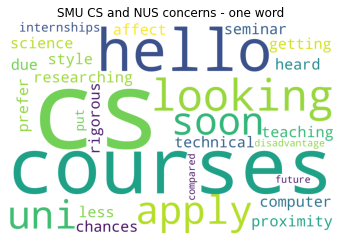

In [64]:
smu_nus_body = only_nus.iloc[:, [1]]

sw = original_stopwords()
sw.extend(['exactly','x200b' , 'nus', 'smu','boil','nt', "n't",'rlly', 'u','hi', 'tat', 'much', 'sure', 'im', 'thank', 'really', "i'm", 'lol', 'bro', 'cmi', 
           'hahah' , 'one', 'well', 'hey', 'hey,' , 'also', 'would' , 'bat', 'right'])

sentences = []
for sentence in smu_nus_body["body"]:
    #sentences = []
    if len(sentence.lower().strip()) > 0 and 'https' not in sentence.lower():
        print(sentence)
        sentences.append(sentence.lower())
    
    
single_word = token_fn(sentences, 1, sw)
wc_fn(single_word, 'SMU CS and NUS concerns - one word', 30)

# double_word = token_fn(sentences, 2, sw)
# wc_fn(double_word, 'SMU CS and NUS concerns - two words', 30)

# triple_word = token_fn(sentences, 3, sw)
# wc_fn(triple_word, 'SMU CS and NUS concerns - three words', 30)

In [61]:
# #Total number of insights

smu_ntu_comments = only_ntu.iloc[:, [2]]

sentences = []
noOfThread = 0
totalComments = 0
for commentArray in smu_ntu_comments["comments"]:
    noOfThread += 1
    valueArray = 0
    for comment in commentArray:
        valueArray += 1
        totalComments += 1

print(noOfThread , ' no of Threads and' , totalComments , 'Comments for all Threads')
print('Average comments per thread: ' , totalComments/noOfThread)

17  no of Threads and 120 Comments for all Threads
Average comments per thread:  7.0588235294117645


In [ ]:
## DDP & LAW CS RELATED

In [44]:
#Finding for SMU, NUS, Biz
only_nus = df[df['title'].str.contains('NUS')]
qn_content =""
for line in only_nus['title']:
    #print(line)
    if 'nus' in line.lower() and 'business' in line.lower() and 'cs' in line.lower(): 
        qn_content += line.lower() + ' '    
        print(line)
        
#results no thread about biz with NUS

In [45]:
#Finding for SMU, NUS, Law
only_nus = df[df['title'].str.contains('NUS')]
qn_content =""
for line in only_nus['title']:
    if 'nus' in line.lower() and 'law' in line.lower() and 'cs' in line.lower(): 
        qn_content += line.lower() + ' '    
        print(line)
        
#results no thread about law with NUS